In [1]:
import numpy as np
import pandas as pd

In [2]:
import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./notebook.ipynb
./student_habits_performance.csv


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap

In [5]:
# load dataframe
df = pd.read_csv("./student_habits_performance.csv")
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [7]:
print(f"column names: {df.columns.tolist()}")
print(f"number of rows: {df.shape[0]}")

column names: ['student_id', 'age', 'gender', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'part_time_job', 'attendance_percentage', 'sleep_hours', 'diet_quality', 'exercise_frequency', 'parental_education_level', 'internet_quality', 'mental_health_rating', 'extracurricular_participation', 'exam_score']
number of rows: 1000


In [8]:
# Preprocess Data
# - handling missing
# - categorize if necessary
# - ensure no missing data exam score
df.dropna(subset=["exam_score"], inplace=True)
print(f"number of rows after drop na: {df.shape[0]}")

number of rows after drop na: 1000


In [9]:
# check and covert categorical features
df = pd.get_dummies(df, drop_first=True) # one-hot encoding of categorical vars
df.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,student_id_S1001,...,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
0,23,0.0,1.2,1.1,85.0,8.0,6,8,56.2,False,...,False,False,False,False,False,False,True,False,False,True
1,20,6.9,2.8,2.3,97.3,4.6,6,8,100.0,True,...,False,False,False,True,False,True,False,False,False,False
2,21,1.4,3.1,1.3,94.8,8.0,1,1,34.3,False,...,True,False,False,False,True,True,False,False,True,False
3,23,1.0,3.9,1.0,71.0,9.2,4,1,26.8,False,...,False,False,False,False,True,False,True,True,False,True
4,19,5.0,4.4,0.5,90.9,4.9,3,1,66.4,False,...,False,False,False,False,False,False,True,True,False,False


In [10]:
if 'student_id' in df.columns:
    df = df.drop(columns=['student_id'])

In [11]:
# define X (features) and y (target)
x = df.drop(columns=['exam_score']) # features excluding 'exam_score'
y = df['exam_score'] # target variable

In [12]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [13]:
# Train a Random Forest Model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
y_pred = model.predict(X_test)

In [15]:
# evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 6.313139379104505


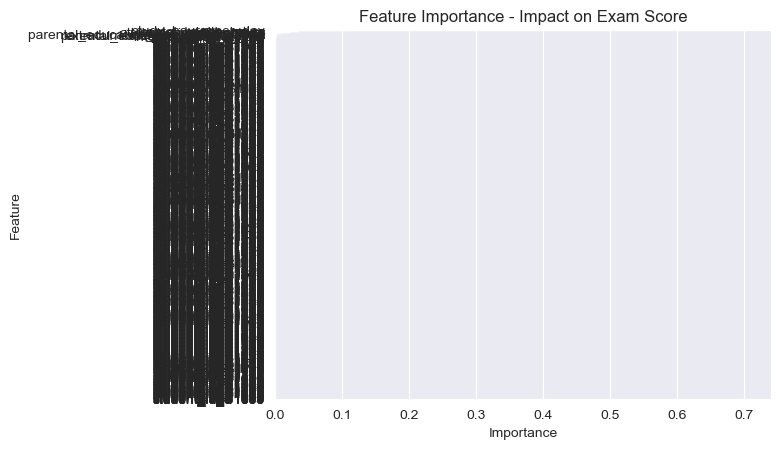

In [16]:
# feature importance
feature_importance = pd.DataFrame(model.feature_importances_,
                                  index=x.columns,
                                  columns=['importance']).sort_values('importance', ascending=False)

sns.barplot(x=feature_importance['importance'], y=feature_importance.index)
plt.title("Feature Importance - Impact on Exam Score")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [17]:
# print the top 10 features for reference when using the advisor function
print("Top 10 Importance Features: ")
print(feature_importance.head(10))

Top 10 Importance Features: 
                       importance
study_hours_per_day      0.705491
mental_health_rating     0.103959
social_media_hours       0.034797
sleep_hours              0.034199
netflix_hours            0.032009
exercise_frequency       0.022489
attendance_percentage    0.017736
age                      0.007451
diet_quality_Good        0.002247
gender_Male              0.002186


In [20]:
def virtual_advisor(input_data_dict):
    # create a dataframe from the input dict
    input_df = pd.DataFrame([input_data_dict])

    # one-hot encode categorical var if needed
    categorical_cols = [col for col in df.columns if col != 'exam_score' and df[col].dtype == 'object']

    # perform one-hot encoding if necessary
    if categorical_cols:
        # after one-hot encoding, drop the original col
        input_df = pd.get_dummies(input_df, drop_first=True)

    # create a dataframe with all features from training model, filled with zeros
    pred_df = pd.DataFrame(0, index=[0], columns=x.columns)

    # fill in the values we have from input_df
    for col in input_df.columns:
        if col in pred_df.columns:
            pred_df[col] = input_df[col]

    # make exam score prediction
    pred_score = model.predict(pred_df)[0]

    # extract key habit var for advice (if they exist in the input)
    study_hours = input_data_dict.get('study_hours', None)
    sleep_hours = input_data_dict.get('sleep_hours', None)
    screen_time = input_data_dict.get('social_media_hours', None)
    exercise_freq = input_data_dict.get('exercise_frequency', None)

    advice = ""

    if study_hours is not None and study_hours < 3:
        advice += "📚 Consider studying more, aim for at least 3 hours daily. "
    if sleep_hours is not None and sleep_hours < 7:
        advice += "😴 You need more sleep for better cognitive performance. Try 7–8 hours. "
    if screen_time is not None and screen_time > 5:
        advice += "📱 Try to reduce screen time, especially before bed. "
    if exercise_freq is not None and exercise_freq < 3:
        advice += "🏃‍♀️ Regular physical activity (at least 3 times a week) can boost focus and energy. "

    if pred_score >= 80:
        advice += "🎉 Great job! You're on track for high academic success. Keep up the hard work!"
    else:
        advice += "📈 You have room for improvement, but with better habits, you can improve your score!"

    return pred_score, advice



In [21]:
# test with student data
student_data = {
    'study_hours_per_day': 2,
    'sleep_hours': 6,
    'social_media_hours': 7,
    'exercise_frequency': 1
    # Add any other relevant features from your dataset
}

score, advice = virtual_advisor(student_data)
print(f"score: {score}")
print(f"advice: \n{advice}")

score: 46.989
advice: 
😴 You need more sleep for better cognitive performance. Try 7–8 hours. 📱 Try to reduce screen time, especially before bed. 🏃‍♀️ Regular physical activity (at least 3 times a week) can boost focus and energy. 📈 You have room for improvement, but with better habits, you can improve your score!
